# TESLA Stock Price Forecasting LSTM

## 1. Preprocessing

In [4]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

### Read Data

In [7]:
df = pd.read_csv('TSLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-06-21,224.603333,243.576660,224.333328,237.036667,237.036667,122793000
1,2022-06-22,234.503326,246.833328,233.826660,236.086670,236.086670,101107500
2,2022-06-23,237.906662,239.316666,228.636673,235.070007,235.070007,104202600
3,2022-06-24,237.470001,246.066666,236.086670,245.706665,245.706665,95770800
4,2022-06-27,249.366669,252.070007,242.566666,244.919998,244.919998,89178300


In [51]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
245,2023-06-12,247.940002,250.970001,244.589996,249.830002,249.830002,150337900
246,2023-06-13,253.509995,259.679993,251.339996,258.709991,258.709991,162384300
247,2023-06-14,260.170013,261.570007,250.500000,256.790009,256.790009,170575500
248,2023-06-15,248.399994,258.950012,247.289993,255.899994,255.899994,160171200
249,2023-06-16,258.920013,263.600006,257.209991,260.540009,260.540009,167563700


In [8]:
train_dates = pd.to_datetime(df['Date'])

In [18]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
# print(train_dates.tail(15)) #Check last few dates. 


In [21]:
#Variables for training
cols = df.columns.to_list()[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [22]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

<Axes: >

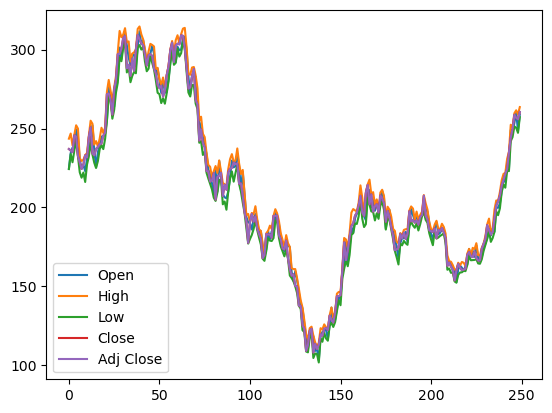

In [23]:
df_for_training.tail(5000).plot.line()

### Normalize the dataset

In [24]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training) # We have 5 columns 
df_for_training_scaled = scaler.transform(df_for_training)

### Prepare train test set

In [25]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape)) 

trainX shape == (236, 14, 5).
trainY shape == (236, 1).


In [31]:
# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [34]:
# fit the model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
14/14 [==============================] - 8s 570ms/step - loss: 0.0890 - val_loss: 0.2049
Epoch 2/10
14/14 [==============================] - 8s 537ms/step - loss: 0.0814 - val_loss: 0.1798
Epoch 3/10
14/14 [==============================] - 8s 539ms/step - loss: 0.0807 - val_loss: 0.1575
Epoch 4/10
14/14 [==============================] - 8s 540ms/step - loss: 0.0643 - val_loss: 0.1655
Epoch 5/10
14/14 [==============================] - 8s 541ms/step - loss: 0.0864 - val_loss: 0.1409
Epoch 6/10
14/14 [==============================] - 7s 537ms/step - loss: 0.0747 - val_loss: 0.1195
Epoch 7/10
14/14 [==============================] - 8s 539ms/step - loss: 0.0603 - val_loss: 0.1192
Epoch 8/10
14/14 [==============================] - 7s 537ms/step - loss: 0.0666 - val_loss: 0.1089
Epoch 9/10
14/14 [==============================] - 7s 531ms/step - loss: 0.0583 - val_loss: 0.1239
Epoch 10/10
14/14 [==============================] - 7s 533ms/step - loss: 0.0447 - val_loss: 0.0923

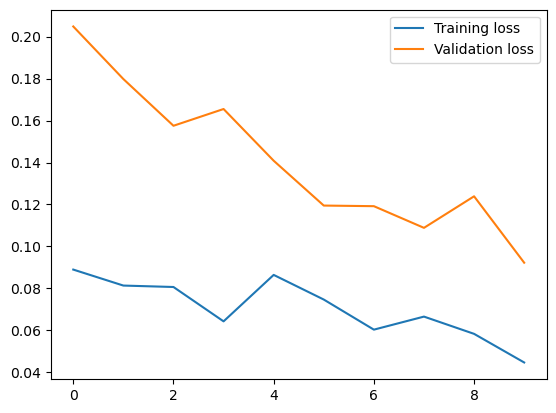

In [35]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [36]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

[Timestamp('2023-05-25 00:00:00'), Timestamp('2023-05-26 00:00:00'), Timestamp('2023-05-30 00:00:00'), Timestamp('2023-05-31 00:00:00'), Timestamp('2023-06-01 00:00:00'), Timestamp('2023-06-02 00:00:00'), Timestamp('2023-06-05 00:00:00'), Timestamp('2023-06-06 00:00:00'), Timestamp('2023-06-07 00:00:00'), Timestamp('2023-06-08 00:00:00'), Timestamp('2023-06-09 00:00:00'), Timestamp('2023-06-12 00:00:00'), Timestamp('2023-06-13 00:00:00'), Timestamp('2023-06-14 00:00:00'), Timestamp('2023-06-15 00:00:00')]
1/1 [==============================] - 1s 538ms/step


In [37]:
prediction # It is scaled.

array([[-0.4997477 ],
       [-0.4596119 ],
       [-0.397279  ],
       [-0.33766764],
       [-0.27822044],
       [-0.20941451],
       [-0.13942896],
       [-0.07578334],
       [-0.00476189],
       [ 0.0715787 ],
       [ 0.17537874],
       [ 0.29733765],
       [ 0.4398418 ],
       [ 0.5880235 ],
       [ 0.71999323]], dtype=float32)

In [38]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [42]:

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
df_forecast.head()

,Date,Open
0,2023-05-25,184.675522
1,2023-05-26,186.732101
2,2023-05-30,189.926071
3,2023-05-31,192.980591
4,2023-06-01,196.026703


In [61]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-6-3']
original.head()

/var/folders/g_/wx182l8j3rjdrb5rv53tf7180000gn/T/ipykernel_37089/1653884869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


,Date,Open
0,2022-06-21,224.603333
1,2022-06-22,234.503326
2,2022-06-23,237.906662
3,2022-06-24,237.470001
4,2022-06-27,249.366669


<Axes: xlabel='Date', ylabel='Open'>

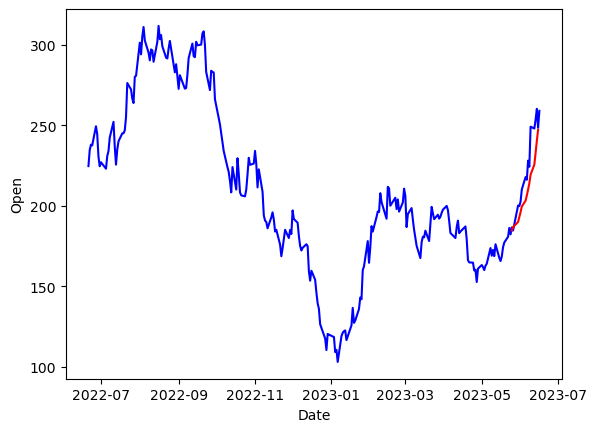

In [62]:

sns.lineplot(x=original['Date'], y=original['Open'],color='blue')
sns.lineplot(x=df_forecast['Date'], y=df_forecast['Open'],color='red') # Predicted